In [1]:
! pip install pandas

In [2]:
! pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 53kB/s 


In [3]:
!pip install keras

In [5]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.9.0
GPU is available


In [6]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet152V2 import ResNet152V2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from glob import glob

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wH49GwWFhZBaaMDupJKbxcLtWAOMe7kVoMhG17O4J3U0YUixoLYxGk
Mounted at /content/drive


# New Section

In [8]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/My Drive/Colab Notebooks/Chest_Xray/train'
valid_path = '/content/drive/My Drive/Colab Notebooks/Chest_Xray/test'

In [9]:
# Import the VGG19 library as shown below and add preprocessing layer to the front of VGG19",
# Here we will be using imagenet weights\n"
vgg= VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 3s 0us/step


In [10]:
# don't train existing weights\n",
for layer in vgg.layers:
    layer.trainable = False

In [11]:
# useful for getting number of output classes
folders = glob('/content/drive/My Drive/Colab Notebooks/Chest_Xray/train/*')
len(folders)

2

In [12]:
folders[0]

'/content/drive/My Drive/Colab Notebooks/Chest_Xray/train/NORMAL'

In [13]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [14]:
prediction=Dense(len(folders), activation='softmax')(x)

In [15]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [16]:

# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [17]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [19]:

# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/Chest_Xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [20]:
test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/Chest_Xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [21]:

# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=3,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
163/163 [==============================] - 2748s 17s/step - loss: 0.2468 - accuracy: 0.9086 - val_loss: 0.2722 - val_accuracy: 0.9038
Epoch 2/3
163/163 [==============================] - 108s 660ms/step - loss: 0.1447 - accuracy: 0.9461 - val_loss: 0.2804 - val_accuracy: 0.9054
Epoch 3/3
163/163 [==============================] - 108s 660ms/step - loss: 0.1069 - accuracy: 0.9601 - val_loss: 0.2681 - val_accuracy: 0.9087


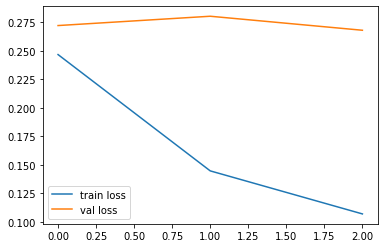

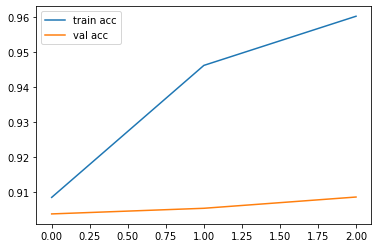

<Figure size 432x288 with 0 Axes>

In [22]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [23]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('Xray_model_vgg19.h5')

In [24]:
y_pred = model.predict(test_set)

In [25]:
y_pred

array([[0.00276397, 0.9972361 ],
       [0.03472053, 0.9652795 ],
       [0.00195237, 0.9980476 ],
       ...,
       [0.00139107, 0.998609  ],
       [0.02212068, 0.97787935],
       [0.9537627 , 0.04623732]], dtype=float32)

In [26]:

import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [27]:
y_pred

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,

In [28]:
len(y_pred)

624

In [29]:
np.array(y_pred==0).sum()

205

In [30]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [31]:
model=load_model('Xray_model_vgg19.h5')

In [53]:
img=image.load_img('/content/drive/My Drive/Colab Notebooks/Chest_Xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg',target_size=(224,224))


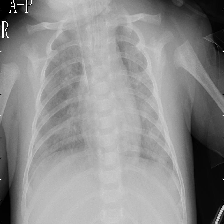

In [54]:
img

In [55]:
y=image.img_to_array(img)
y


array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 6.,  6.,  6.],
        [ 6.,  6.,  6.],
        [ 6.,  6.,  6.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 6.,  6.,  6.],
        [ 6.,  6.,  6.],
        [ 6.,  6.,  6.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 6.,  6.,  6.],
        [ 6.,  6.,  6.],
        [ 6.,  6.,  6.]],

       ...,

       [[ 0.,  0.,  0.],
        [12., 12., 12.],
        [ 4.,  4.,  4.],
        ...,
        [12., 12., 12.],
        [20., 20., 20.],
        [ 4.,  4.,  4.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 4.,  4.,  4.],
        ...,
        [11., 11., 11.],
        [ 0.,  0.,  0.],
        [ 3.,  3.,  3.]],

       [[ 7.,  7.,  7.],
        [ 0.,  0.,  0.],
        [ 4.,  4.,  4.],
        ...,
        [12., 12., 12.],
        [ 2.,  2.,  2.],
        [15., 15., 15.]]

In [56]:
y.shape

(224, 224, 3)

In [57]:
y=np.expand_dims(y,axis=0)
y.shape

(1, 224, 224, 3)

In [58]:
imgy=preprocess_input(y)
imgy.shape

(1, 224, 224, 3)

In [59]:
imgy=imgy/255


In [60]:
preds= model.predict(imgy)
preds



array([[1.9107407e-04, 9.9980897e-01]], dtype=float32)

In [61]:
a=np.argmax(preds, axis=1)
a

array([1])

In [62]:
if(a==0):
    print("Normal")
else:
    print("Pneumonia")

Pneumonia
